<h1> Convolutional Neural Network Implementation on CIFAR-10 Dataset </h1>

# CIFAR-10 Dataset

The CIFAR-10 dataset is a widely used benchmark in the field of computer vision and machine learning. It was developed by researchers at the Canadian Institute For Advanced Research (CIFAR). The dataset consists of **60,000** **32×32** pixel color photographs of objects from **10** different classes. The class labels and their associated integer values are as follows:


<img src="https://miro.medium.com/max/709/1*LyV7_xga4jUHdx4_jHk1PQ.png" style="max-width:480px">


These images are relatively small, much smaller than typical photographs, making them suitable for computer vision research.

CIFAR-10 has become a well-understood dataset and is commonly used for benchmarking computer vision algorithms. The problem is considered "solved," with it being relatively straightforward to achieve an 80% classification accuracy. The highest performance on this dataset is achieved by employing deep learning convolutional neural networks, which can achieve a classification accuracy exceeding 90% on the test dataset.


In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

100%|██████████| 170498071/170498071 [00:13<00:00, 12540924.14it/s]


Extracting ./CIFAR10/train/cifar-10-python.tar.gz to ./CIFAR10/train


100%|██████████| 170498071/170498071 [00:13<00:00, 12397021.18it/s]


Extracting ./CIFAR10/test/cifar-10-python.tar.gz to ./CIFAR10/test


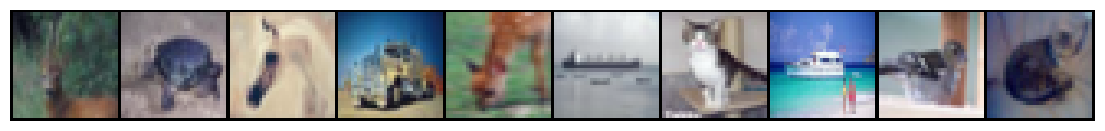

deer frog horse truck deer ship cat ship bird cat 

In [ ]:


mean = [0.4914, 0.4822, 0.4465]
std = [0.2470, 0.2435, 0.2616]

#Initializing normalizing transform for the dataset
normalize_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = mean,
                                     std = std)])

#Downloading the CIFAR10 dataset into train and test sets
train_dataset = torchvision.datasets.CIFAR10(
    root="./CIFAR10/train", train=True,
    transform=normalize_transform,
    download=True)



test_dataset = torchvision.datasets.CIFAR10(
    root="./CIFAR10/test", train=False,
    transform=normalize_transform,
    download=True)

#Generating data loaders from the corresponding datasets
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)  # MMMR --- Shuffle needs to be true.
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

#Plotting 10 images from the 1st batch
#Defining plotting settings
plt.rcParams['figure.figsize'] = 14, 6

dataiter = iter(train_loader)
images, labels = next(dataiter)
plt.imshow(np.transpose(torchvision.utils.make_grid(
  images[:10], normalize=True, padding=1, nrow=10).numpy(), (1, 2, 0)))
plt.axis('off')
plt.show()

# Printing Labels
label_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog",
               "horse", "ship", "truck"]
labels_now = labels[:10]
for x in labels_now.tolist():
  print(label_names[x], end=" ")

np.transpose(..., (1, 2, 0)): This line transposes the grid of images to change the order of dimensions. This is often necessary because the default order of dimensions in PyTorch tensors is (batch_size, channels, height, width), but Matplotlib expects the order to be (height, width, channels). The np.transpose function is used to make this dimension adjustment.

## Step 2: Plotting the Class Distribution of the Dataset

It's generally a good practice to visualize the class distribution of the training set when working with a dataset. This step is essential for checking whether the dataset is balanced or not, which can have implications for the training of machine learning models.

To plot the class distribution, follow these steps:

1. Iterate over the entire training dataset in batches.

2. For each instance in the batch, collect its respective class label.

3. Calculate the counts of unique classes in the training set.

4. Create a plot to visualize the class distribution.

Checking the class distribution is crucial because an imbalanced dataset, where some classes have significantly more instances than others, can affect the performance of machine learning models. In such cases, techniques like class weighting or data augmentation may be required to address the imbalance and ensure that the model learns from all classes effectively.


Text(0, 0.5, 'Number of training instances')

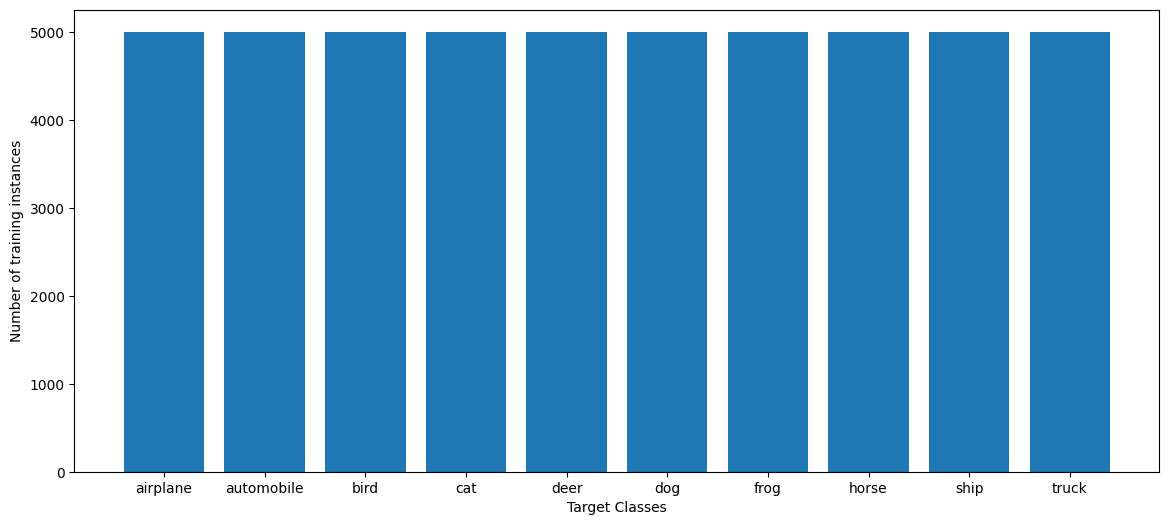

In [ ]:
#Iterating over the training dataset and storing the target class for each sample
classes = []
for batch_idx, data in enumerate(train_loader, 0):
    x, y = data
    classes.extend(y.tolist())

#Calculating the unique classes and the respective counts and plotting them
unique, counts = np.unique(classes, return_counts=True)
names = list(train_dataset.class_to_idx.keys())
plt.bar(names, counts)
plt.xlabel("Target Classes")
plt.ylabel("Number of training instances")

As illustrated in Figure 2, it is evident that each of the ten classes in the dataset has approximately an equal number of training samples. Therefore, there is no need to undertake additional steps to rebalance the dataset. The balanced distribution of training samples across classes is advantageous as it helps prevent potential biases and ensures that the machine learning model is exposed to a representative amount of data from each class during training.


## Defining the Model (Convolutional Neural Network)

For this tutorial, we will use a convolutional neural network, using the `nn.Conv2d` class from PyTorch.

> The 2D convolution is a fairly simple operation at heart: you start with a kernel, which is simply a small matrix of weights. This kernel “slides” over the 2D input data, performing an elementwise multiplication with the part of the input it is currently on, and then summing up the results into a single output pixel. - [Source](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1)

<img src="https://miro.medium.com/max/1070/1*Zx-ZMLKab7VOCQTxdZ1OAw.gif" style="max-width:400px;">

.

## Step 3: Implementing the CNN Architecture
<img src="https://miro.medium.com/v2/resize:fit:1400/1*ZpZRWufr2G6usGaT8FtDBg.gif" width="700">

For the architecture of our Convolutional Neural Network (CNN), we will employ a relatively simple model, which consists of the following components:

- **Convolutional Layers**: The CNN architecture includes three convolutional layers with depths of 32, 64, and 64, respectively. Each of these convolutional layers performs a convolution operation using a 3x3 convolution filter.

- **Activation Functions**: After each convolution operation, a Rectified Linear Unit (ReLU) activation function is applied. ReLU introduces nonlinearity into the system, allowing the network to learn complex patterns and features from the data.

- **Max-Pooling**: Following the ReLU activation, each convolutional layer is followed by a max-pooling operation using a 2x2 filter. Max-pooling reduces the dimensionality of the feature maps, which can help reduce computational complexity and increase the network's ability to capture important features.

- **Flattening**: After the convolutional blocks, the multidimensional feature maps are flattened into a lower-dimensional structure. This prepares the data for the subsequent classification blocks.

- **Fully Connected Layers**: The classification section of the model consists of two fully connected layers. The first linear layer serves as an intermediate step, and the last output layer, also a linear layer, has ten neurons, one for each of the ten unique classes in our dataset. These output neurons produce the final classification results.

The chosen architecture balances simplicity and effectiveness for the given task, allowing the CNN to learn and extract relevant features from the CIFAR-10 dataset. The architecture's design is an essential component of the overall deep learning model and plays a critical role in the model's performance.
<br>

The architecture is as follows:
<br>
<br>
<img src="https://media.geeksforgeeks.org/wp-content/uploads/20220128190258/cnnarchitecture-660x368.png" width="700">
<br>
<br>

To build our model, we will create a CNN class that inherits from the `torch.nn.Module` class, which allows us to leverage PyTorch utilities for building and training neural networks. Additionally, we will use the `torch.nn.Sequential` container to organize our layers in a sequential fashion.

The following layers are key components of our model:

- **Conv2D**: The Convolutional layer responsible for performing convolution operations.
- **ReLU**: The Rectified Linear Unit (ReLU) activation function, introducing nonlinearity into the system.
- **MaxPool2D**: The Max-Pooling layer for reducing the dimensionality of feature maps.

We have chosen to include a padding of 1 in the Conv2D layers to provide sufficient learning space for the kernel. Padding extends the coverage area of the image, especially around the pixels in the outer frame, which can be beneficial for feature extraction.

After the convolutional blocks, we incorporate fully connected layers using the `Linear()` function to perform classification tasks. These layers are essential for making predictions based on the features learned during the convolutional operations.



In [ ]:
# class CNN_old(torch.nn.Module):
# 	def __init__(self):
# 		super().__init__()
# 		self.model = torch.nn.Sequential(
# 			#Input = 3 x 32 x 32, Output = 32 x 32 x 32
# 			torch.nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, padding = 1),
# 			torch.nn.ReLU(),
# 			#Input = 32 x 32 x 32, Output = 32 x 16 x 16
# 			torch.nn.MaxPool2d(kernel_size=2),

# 			#Input = 32 x 16 x 16, Output = 64 x 16 x 16
# 			torch.nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1),
# 			torch.nn.ReLU(),
# 			#Input = 64 x 16 x 16, Output = 64 x 8 x 8
# 			torch.nn.MaxPool2d(kernel_size=2),

# 			#Input = 64 x 8 x 8, Output = 64 x 8 x 8
# 			torch.nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
# 			torch.nn.ReLU(),
# 			#Input = 64 x 8 x 8, Output = 64 x 4 x 4
# 			torch.nn.MaxPool2d(kernel_size=2),

# 			torch.nn.Flatten(),
# 			torch.nn.Linear(64*4*4, 512),
# 			torch.nn.ReLU(),
# 			torch.nn.Linear(512, 10)
# 		)

# 	def forward(self, x):
# 		return self.model(x)

#################--- Accessing weights and activations in this style can be a problem https://stackoverflow.com/questions/56435961/how-to-access-the-network-weights-while-using-pytorch-nn-sequential

class CNN(torch.nn.Module):
	def __init__(self):
		super().__init__()
		# --- Conv layer Set 1
		self.l1_conv = torch.nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, padding = 1) # 3 * 32 * 32 ----> Conv2D : 32c3w1s1p ---->
		self.l1_relu = torch.nn.ReLU()    #  ----> ReLU --->
		self.l1_maxpool = torch.nn.MaxPool2d(kernel_size=2) # ----> Maxpool2D : 2w1s0p --->
		# --- Conv layer Set 2
		self.l2_conv = torch.nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1)   #  ----> Conv2D : 64c3w1s1p ---->
		self.l2_relu = torch.nn.ReLU()		#     ----> ReLU --->
		self.l2_maxpool = torch.nn.MaxPool2d(kernel_size=2) #    ----> Maxpool2D : 2w1s0p --->
		# --- Conv layer Set 3
		self.l3_conv = torch.nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1)	#  ----> Conv2D : 64c3w1s1p ---->
		self.l3_relu = torch.nn.ReLU()				#     ----> ReLU --->
		self.l3_maxpool = torch.nn.MaxPool2d(kernel_size=2)		#    ----> Maxpool2D : 2w1s0p --->
		# --- FCL
		self.fc_flat = torch.nn.Flatten()			# ------> Flatten ----->
		self.fc_lin1 = torch.nn.Linear(64*4*4, 512)		#  ---------> Linear(512) ------>
		self.fc_relu = torch.nn.ReLU()                #  ---------> ReLu ------->
		self.fc_lin2 = torch.nn.Linear(512, 10)				# ----------> Linear(10) ------>
	def forward(self, x):
		# --- Conv layer Set 1
		x = self.l1_conv(x)
		x = self.l1_relu(x)
		x = self.l1_maxpool(x)
		# ---- Conv layer Set 2
		x = self.l2_conv(x)
		x = self.l2_relu(x)
		x = self.l2_maxpool(x)
		# ---- Conv layer Set 3
		x = self.l3_conv(x)
		x = self.l3_relu(x)
		x = self.l3_maxpool(x)
		# FC layer
		x = self.fc_flat(x)
		x = self.fc_lin1(x)
		x = self.fc_relu(x)
		x = self.fc_lin2(x)
		return x

# Printing model summary

from torchsummary import summary
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_to_analyse = CNN().to(device)
print(model_to_analyse)

summary(model_to_analyse, (3, 32, 32))


CNN(
  (l1_conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (l1_relu): ReLU()
  (l1_maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (l2_conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (l2_relu): ReLU()
  (l2_maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (l3_conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (l3_relu): ReLU()
  (l3_maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_flat): Flatten(start_dim=1, end_dim=-1)
  (fc_lin1): Linear(in_features=1024, out_features=512, bias=True)
  (fc_relu): ReLU()
  (fc_lin2): Linear(in_features=512, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-

## Step 4: Defining Training Parameters and Initiating the Training Process

The training process begins with the selection of the training device, which can be either the CPU or a GPU. Following that, we define our model hyperparameters, which are as follows:

- **Number of Epochs**: We train our models for a total of 50 epochs. This is the number of times the entire training dataset is passed forward and backward through the neural network.

- **Loss Function**: Given that we have a multiclass classification problem, we utilize the Cross-Entropy Loss as our objective function. This loss function is well-suited for classification tasks.

- **Optimizer**: We employ the popular Adam optimizer for parameter optimization. The Adam optimizer helps update model weights efficiently during training. We set the learning rate to 0.001.
With these hyperparameters defined, we initiate the training loop. This loop encompasses the following steps for each batch of data:

1. Calculate the model's outputs for the batch.
2. Compute the loss by comparing the predicted labels with the true labels.

During training, the model learns to make better predictions by minimizing this loss. The process is repeated for all batches in each epoch, gradually improving the model's performance.

To monitor the training progress and ensure that it aligns with the planned training process, we plot the training loss for each respective epoch. This visualization aids in tracking the model's learning curve and assessing its convergence.


Epoch 1/50: Training loss = 1.3919768688623861
Epoch 2/50: Training loss = 0.9754491201447099
Epoch 3/50: Training loss = 0.7999560685108995
Epoch 4/50: Training loss = 0.677150665570403
Epoch 5/50: Training loss = 0.5829416139961203
Epoch 6/50: Training loss = 0.48946708387426097
Epoch 7/50: Training loss = 0.4140451349260862
Epoch 8/50: Training loss = 0.3276610451814769
Epoch 9/50: Training loss = 0.25729154088460576
Epoch 10/50: Training loss = 0.19499158005580267
Epoch 11/50: Training loss = 0.14850433617639724
Epoch 12/50: Training loss = 0.11911742348709832
Epoch 13/50: Training loss = 0.10642371293814744
Epoch 14/50: Training loss = 0.08831409402096363
Epoch 15/50: Training loss = 0.08567648240939126
Epoch 16/50: Training loss = 0.07700846866583047
Epoch 17/50: Training loss = 0.06438997130760032
Epoch 18/50: Training loss = 0.06607732552287104
Epoch 19/50: Training loss = 0.060568269604192974
Epoch 20/50: Training loss = 0.06779951837313983
Epoch 21/50: Training loss = 0.06223

Text(0, 0.5, 'Training loss')

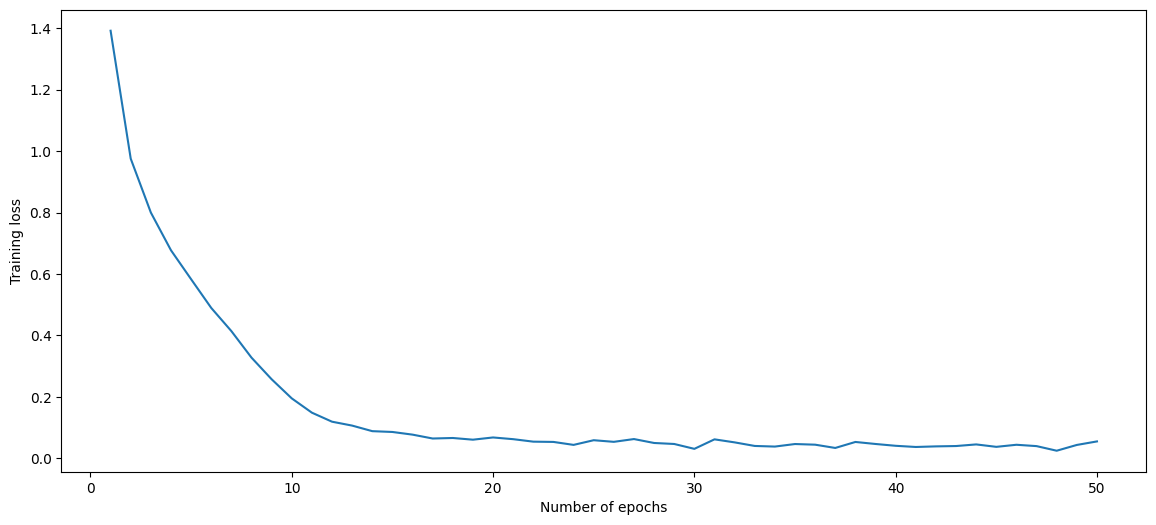

In [ ]:
#Selecting the appropriate training device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CNN().to(device)

#Defining the model hyper parameters
num_epochs = 50
learning_rate = 0.001
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#Training process begins
train_loss_list = []
for epoch in range(num_epochs):
	print(f'Epoch {epoch+1}/{num_epochs}:', end = ' ')
	train_loss = 0

	#Iterating over the training dataset in batches
	model.train()
	for i, (images, labels) in enumerate(train_loader):

		#Extracting images and target labels for the batch being iterated
		images = images.to(device)
		labels = labels.to(device)

		#Calculating the model output and the cross entropy loss
		outputs = model(images)
		loss = criterion(outputs, labels)

		#Updating weights according to calculated loss
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		train_loss += loss.item()

	#Printing loss for each epoch
	train_loss_list.append(train_loss/len(train_loader))
	print(f"Training loss = {train_loss_list[-1]}")

#Plotting loss for all epochs
plt.plot(range(1,num_epochs+1), train_loss_list)
plt.xlabel("Number of epochs")
plt.ylabel("Training loss")


## Step 5: Calculating Model Accuracy on the Test Set

With our model successfully trained, it is crucial to evaluate its performance on the test set. To achieve this, we execute the following steps:

1. **Iterate Over the Test Set**: We iterate over the entire test dataset in batches. This ensures that the model's performance is assessed on all test samples.

2. **Accuracy Calculation**: In each batch, we calculate the accuracy score. This involves comparing the true labels (ground truth) with the predicted labels generated by the trained model. The accuracy score quantifies the model's ability to correctly classify data instances within the test set.

Evaluating the model on a separate test dataset is an essential step to understand how well it generalizes to unseen data. It provides a reliable measure of the model's performance and helps assess its ability to make accurate predictions on real-world data.


In [ ]:
test_acc=0
model.eval()

with torch.no_grad():
    #Iterating over the test dataset in batches
    for i, (images, labels) in enumerate(test_loader):

        images = images.to(device)
        y_true = labels.to(device)

        #Calculating outputs for the batch being iterated
        outputs = model(images)

        #Calculated prediction labels from models
        _, y_pred = torch.max(outputs.data, 1)

        #Comparing predicted and true labels
        test_acc += (y_pred == y_true).sum().item()

    print(f"Test set accuracy = {100 * test_acc / len(test_dataset)} %")

Test set accuracy = 74.19 %


Generating predictions for some sample images

(-0.5, 165.5, 33.5, -0.5)

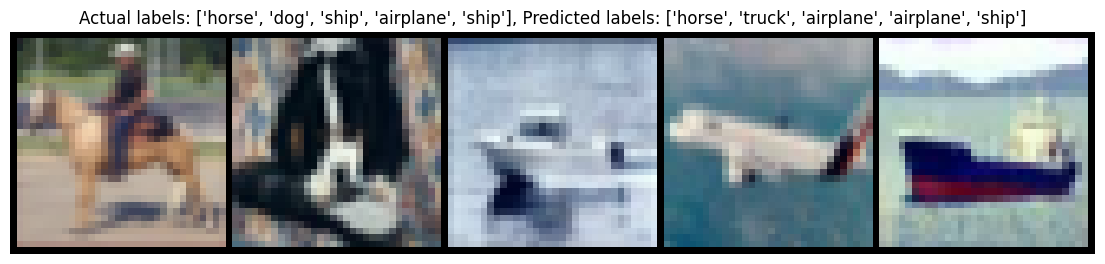

In [ ]:

#Generating predictions for 'num_images' amount of images from the last batch of test set
num_images = 5
y_true_name = [names[y_true[idx]] for idx in range(num_images)]
y_pred_name = [names[y_pred[idx]] for idx in range(num_images)]

#Generating the title for the plot
title = f"Actual labels: {y_true_name}, Predicted labels: {y_pred_name}"

#Finally plotting the images with their actual and predicted labels in the title
plt.imshow(np.transpose(torchvision.utils.make_grid(images[:num_images].cpu(), normalize=True, padding=1).numpy(), (1, 2, 0)))
plt.title(title)
plt.axis("off")


## Visualizing Learned Conv filters and Extracted Features

Here, we observe the learned filters and corresponding features in a layer-wise fashion.
Neural network models are generally referred to as being opaque. This means that they are poor at explaining the reason why a specific decision or prediction was made.

Convolutional neural networks are designed to work with image data, and their structure and function suggest that should be less inscrutable than other types of neural networks.

Specifically, the models are comprised of small linear filters and the result of applying filters called activation maps, or more generally, feature maps.

Both filters and feature maps can be visualized.

For example, we can design and understand small filters, such as line detectors. Perhaps visualizing the filters within a learned convolutional neural network can provide insight into how the model works.

The feature maps that result from applying filters to input images and to feature maps output by prior layers could provide insight into the internal representation that the model has of a specific input at a given point in the model.

CNN(
  (l1_conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (l1_relu): ReLU()
  (l1_maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (l2_conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (l2_relu): ReLU()
  (l2_maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (l3_conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (l3_relu): ReLU()
  (l3_maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_flat): Flatten(start_dim=1, end_dim=-1)
  (fc_lin1): Linear(in_features=1024, out_features=512, bias=True)
  (fc_relu): ReLU()
  (fc_lin2): Linear(in_features=512, out_features=10, bias=True)
)
l1_conv.weight
torch.Size([32, 3, 3, 3])


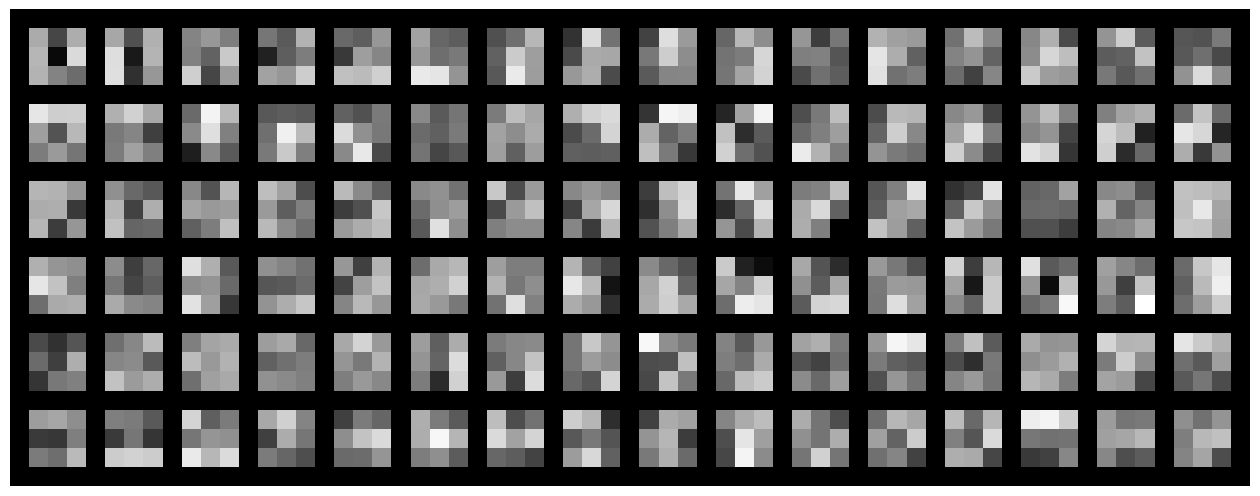

l2_conv.weight
torch.Size([64, 32, 3, 3])


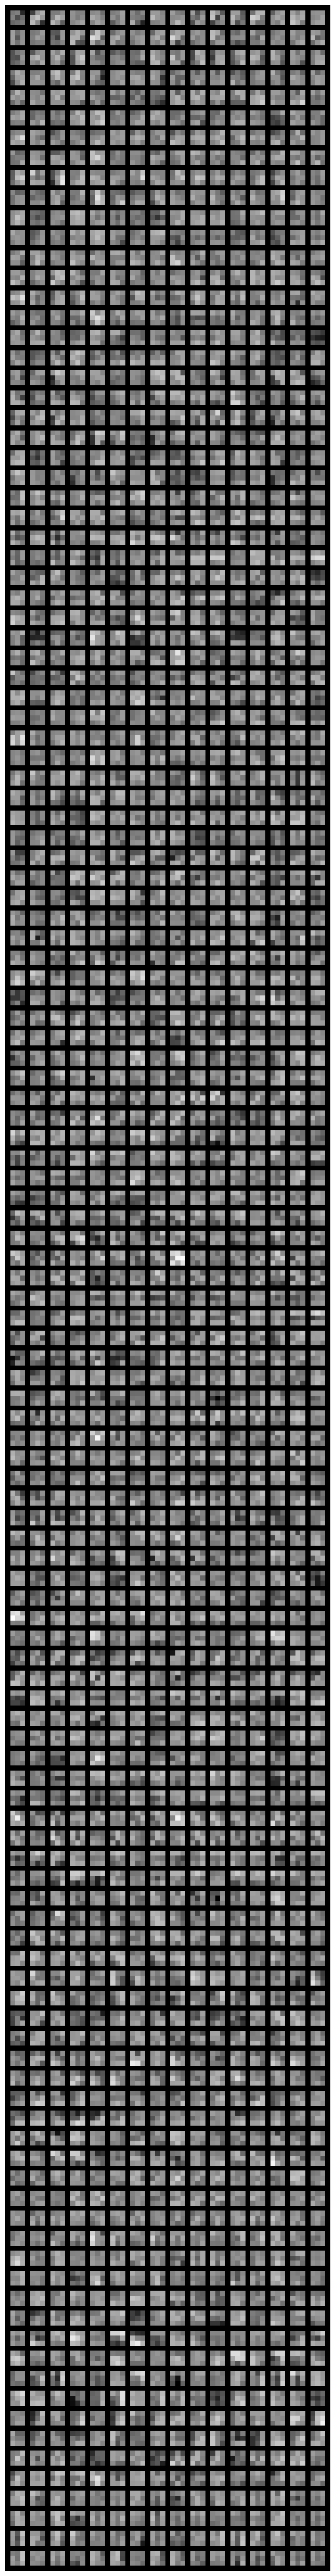

l3_conv.weight
torch.Size([64, 64, 3, 3])


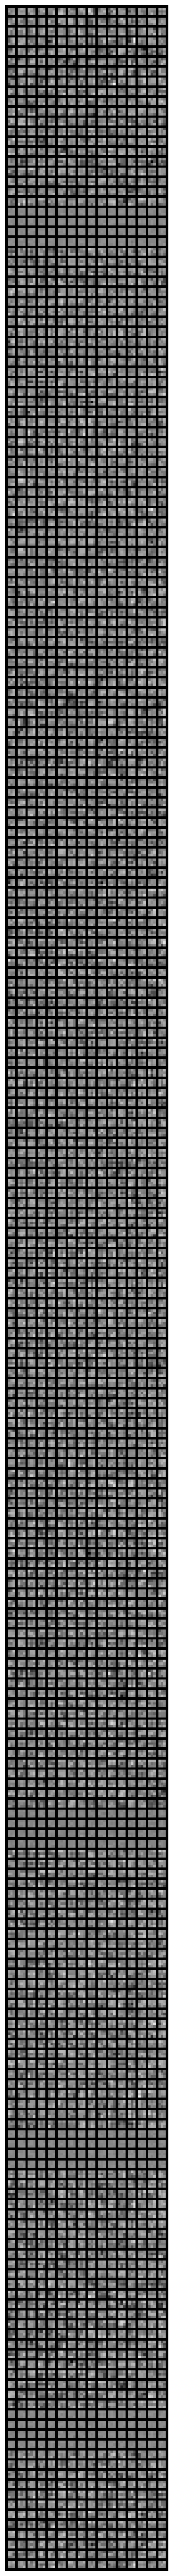

In [ ]:
from torchvision import utils

def visTensor(tensor, ch=0, allkernels=False, nrow=16, padding=1, normalize=True):
  print(tensor.shape)
  n,c,w,h = tensor.shape
  tensor = tensor.view(n*c, -1, w, h)
  #if allkernels: tensor = tensor.view(n*c, -1, w, h)
  #elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)
  rows = np.min((tensor.shape[0] // nrow + 1, 64))
  grid = utils.make_grid(tensor, nrow=nrow, normalize=normalize, padding=padding)
  plt.figure( figsize=(nrow,rows) )
  plt.imshow(grid.numpy().transpose((1, 2, 0)))

print(model)

for name, param in model.named_parameters():
  # print(name, param)
  if 'conv' in name.lower() and 'weight' in name.lower(): #and '3' in name.lower():  # Getting convolution filters only
    print(name)
    visTensor(param.detach().cpu(), ch=0, allkernels=True)
    plt.axis('off')
    plt.ioff()
    plt.show()



Here we visualize the feature maps at each layers.

In [ ]:
def return_layer_input_output(model, inputs):
    """ Author: Mahesh Mohan M R -- mm103@illinois.edu
        The function provides a dictionary with the layer-name and ip/op activations.

        Parameters:
            model (pytorch nnmodule): Network whose parameter number is required.

        Returns:
            layers (str): Which contains the individual layer-name.
            input_lr: Input
            Activation: Activation at each layer
        """

    with torch.no_grad():
        activation = {}
        input_lr = {}

        def get_activation(name):
            def hook(model, input, output):
                activation[name] = output.detach()
                input_lr[name] = input[0].detach()

            return hook

        layer_name = []
        for name, layer in model.named_modules():
            if not ("." in name):
                layer.register_forward_hook(get_activation(name))
                layer_name.append(name)
        output = model(inputs.detach()).detach()
        # Removing the hook or else it will add a overhead
        for name, layer in model.named_modules():
            if not ("." in name):
                layer.register_forward_hook(get_activation(name)).remove()
    return layer_name, input_lr, activation


In [ ]:
def show_image(subset_indices, test_dataset):
  subset = torch.utils.data.Subset(test_dataset, subset_indices)
  testloader_subset = torch.utils.data.DataLoader(subset, batch_size=1, num_workers=0, shuffle=False)
  dataiter_subset = iter(testloader_subset)
  images, labels = next(dataiter_subset)
  print(images.size())
  plt.imshow(np.transpose(torchvision.utils.make_grid(
    images, normalize=True, padding=1, nrow=1).numpy(), (1, 2, 0)))
  plt.axis('off')
  plt.show()
  print(f"Actual labels: {names[labels]}")
  return images, labels

In [ ]:
def visualize_feature_map(model, images, labels):
  layer_name, input_lr, activation = return_layer_input_output(model.cpu(), images.detach().cpu())
  # print(activation)
  for name in layer_name:
    if 'l1' in name.lower() or 'l2' in name.lower() or 'l3' in name.lower():
      if 'relu' in name.lower():
        print(name)
        visTensor(activation.get(name).detach().cpu(), ch=0, allkernels=True, normalize=True)
        plt.axis('off')
        plt.ioff()
        plt.show()


  outputs = model(images)

  #Calculated prediction labels from models
  _, y_pred = torch.max(outputs.data, 1)
  y_true = labels

  print(f"Actual labels: {names[y_true]}, Predicted labels: {names[y_pred]}")

torch.Size([1, 3, 32, 32])


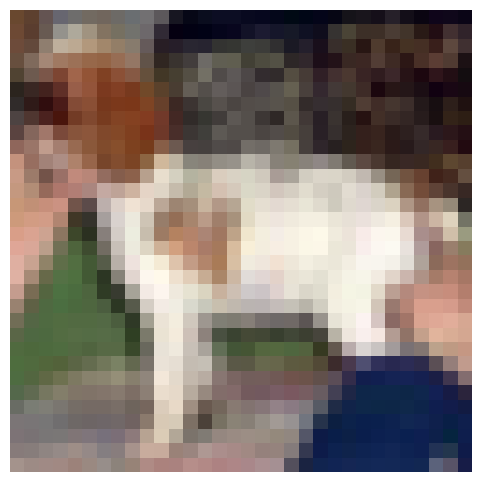

Actual labels: dog


In [ ]:
subset_indices = [12] # select your indices here as a list
image, label = show_image(subset_indices, test_dataset)

l1_relu
torch.Size([1, 32, 32, 32])


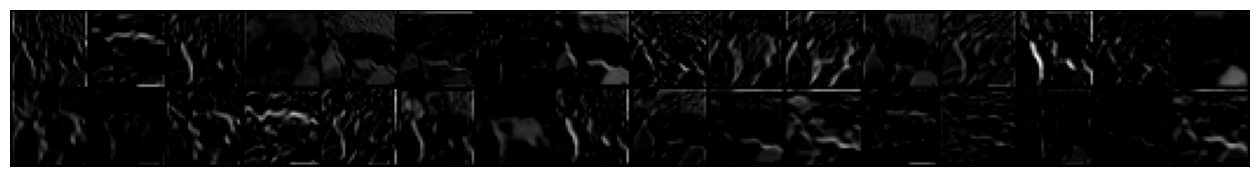

l2_relu
torch.Size([1, 64, 16, 16])


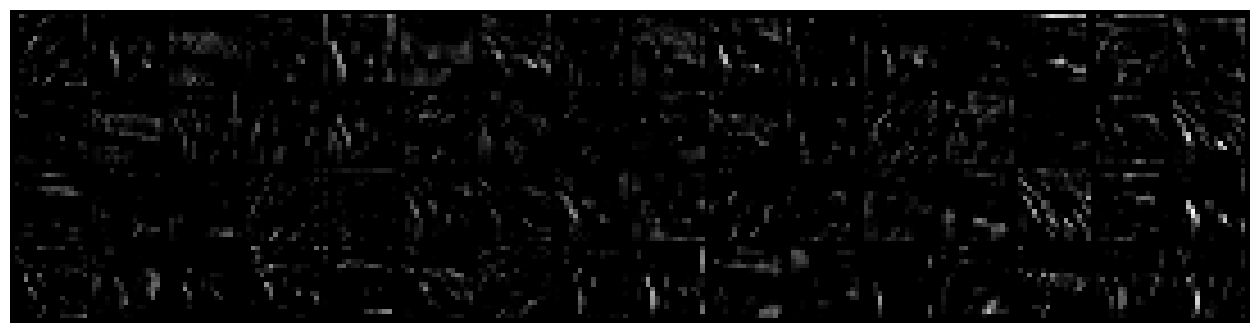

l3_relu
torch.Size([1, 64, 8, 8])


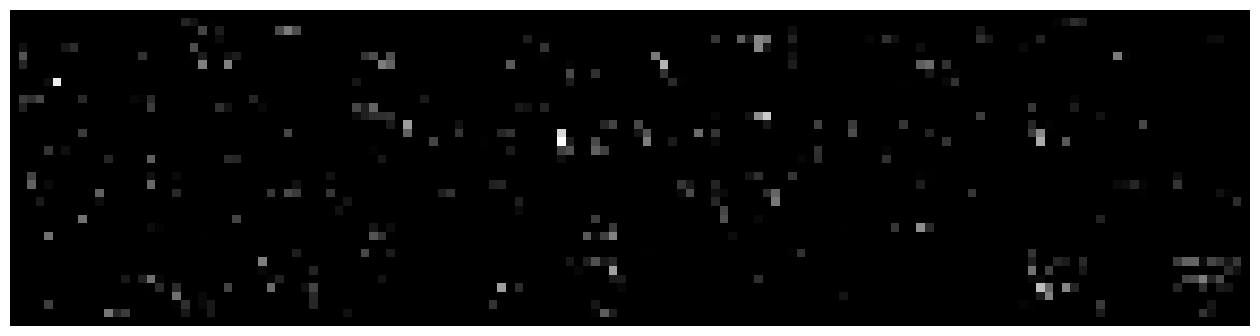

Actual labels: dog, Predicted labels: dog


In [ ]:
visualize_feature_map(model, image, label)

torch.Size([1, 3, 32, 32])


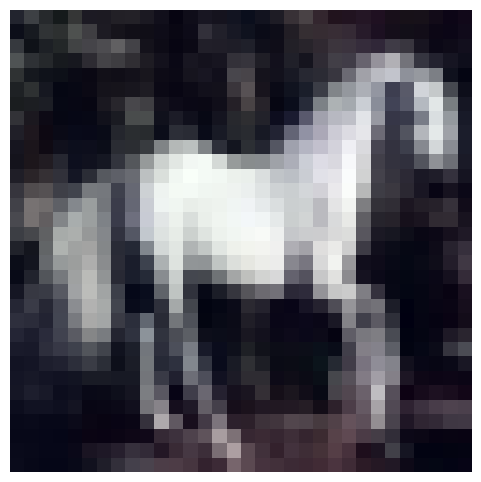

Actual labels: horse


In [ ]:
subset_indices = [13] # select your indices here as a list
image, label = show_image(subset_indices, test_dataset)

l1_relu
torch.Size([1, 32, 32, 32])


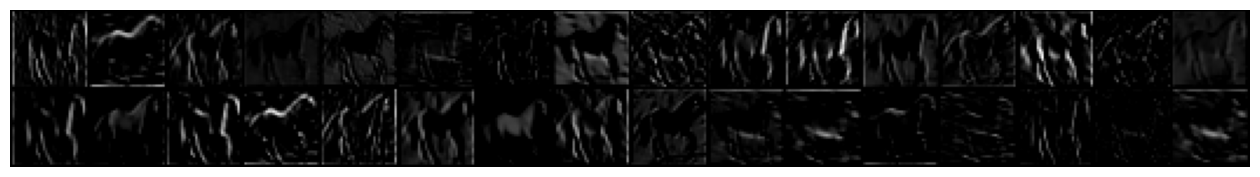

l2_relu
torch.Size([1, 64, 16, 16])


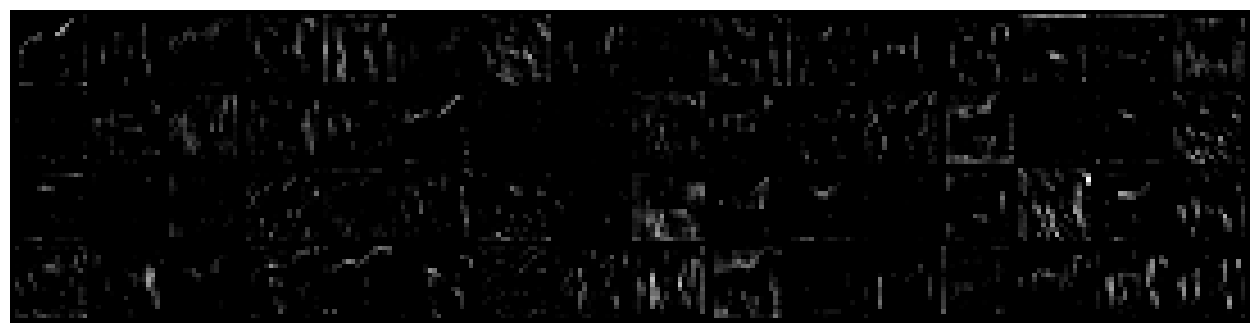

l3_relu
torch.Size([1, 64, 8, 8])


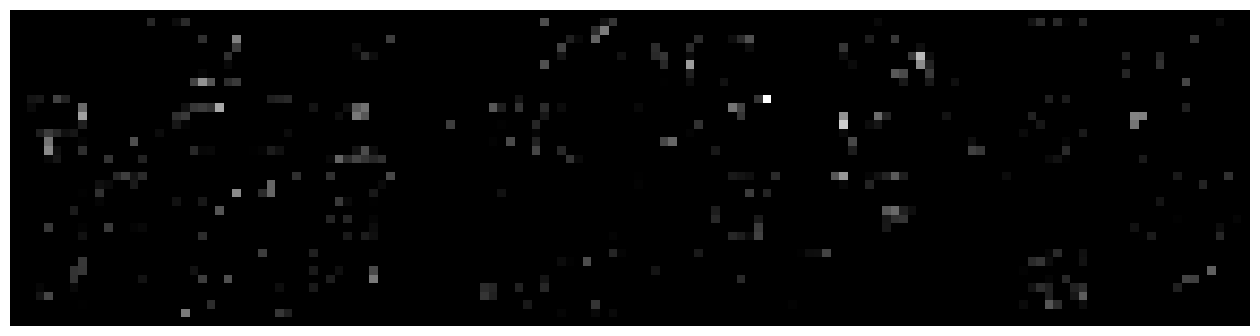

Actual labels: horse, Predicted labels: horse


In [ ]:
visualize_feature_map(model, image, label)

torch.Size([1, 3, 32, 32])


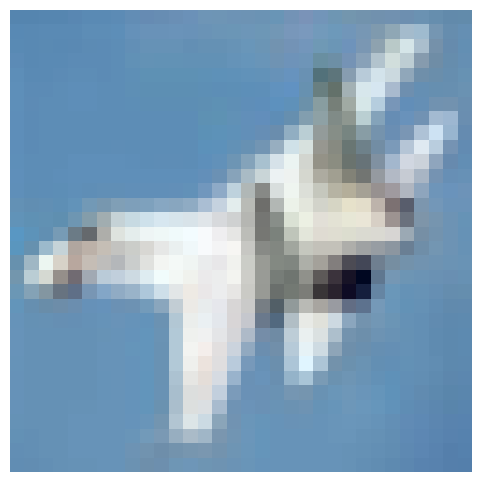

Actual labels: airplane


In [ ]:
subset_indices = [10] # select your indices here as a list
image, label = show_image(subset_indices, test_dataset)

l1_relu
torch.Size([1, 32, 32, 32])


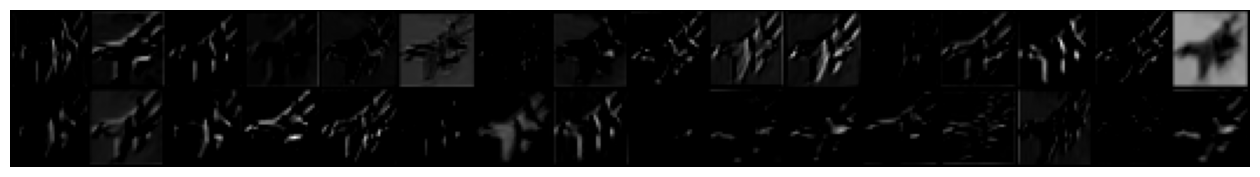

l2_relu
torch.Size([1, 64, 16, 16])


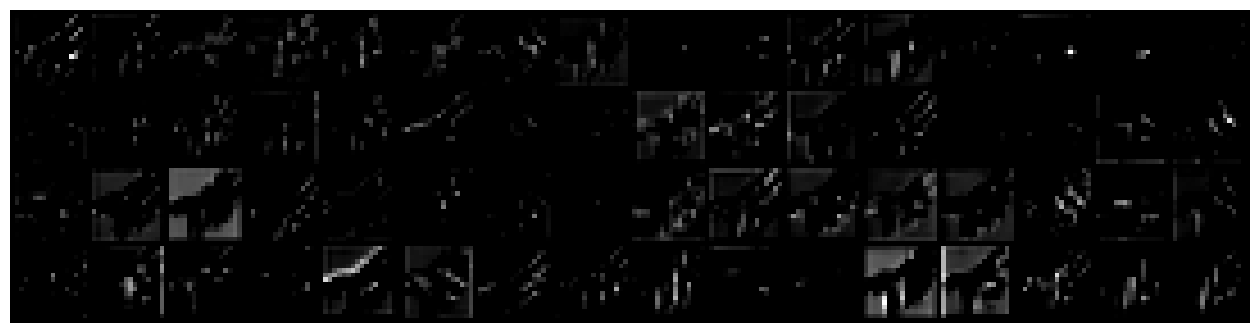

l3_relu
torch.Size([1, 64, 8, 8])


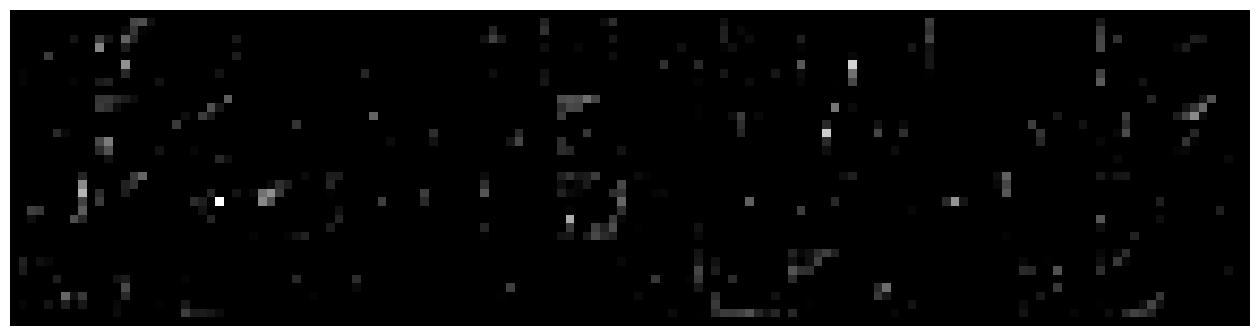

Actual labels: airplane, Predicted labels: airplane


In [ ]:
visualize_feature_map(model, image, label)

In [ ]:
def saliency_map(images):
  # we would run the model in evaluation mode
  X = images
  model.eval()

  # we need to find the gradient with respect to the input image, so we need to call requires_grad_ on it
  X.requires_grad_()

  scores = model(X)

  # Get the index corresponding to the maximum score and the maximum score itself.
  score_max_index = scores.argmax()
  score_max = scores[0,score_max_index]

  score_max.backward()

  saliency, _ = torch.max(X.grad.data.abs(),dim=1)

  # Create a new figure with two subplots
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))  # Adjust the figure size

  # Display the original image on the left subplot
  ax1.imshow(np.transpose(torchvision.utils.make_grid(
    images, normalize=True, padding=0, nrow=1).numpy(), (1, 2, 0))
  )
  ax1.set_axis_off()

  # Display the saliency map as a heatmap on the right subplot
  ax2.imshow(saliency[0], cmap=plt.cm.hot)
  ax2.set_axis_off()

  plt.subplots_adjust(wspace=0)  # Remove space between subplots
  plt.show()

torch.Size([1, 3, 32, 32])


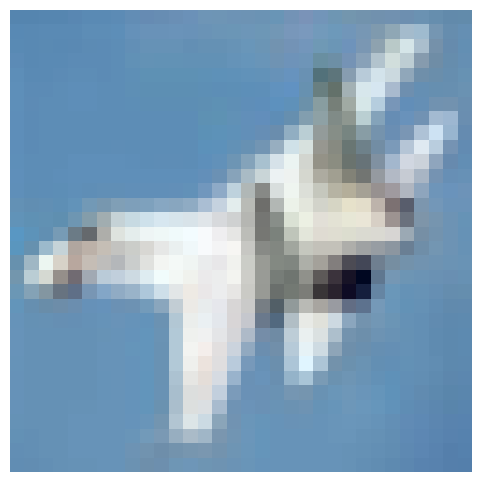

Actual labels: airplane


In [ ]:
subset_indices = [10] # select your indices here as a list
image, label = show_image(subset_indices, test_dataset)

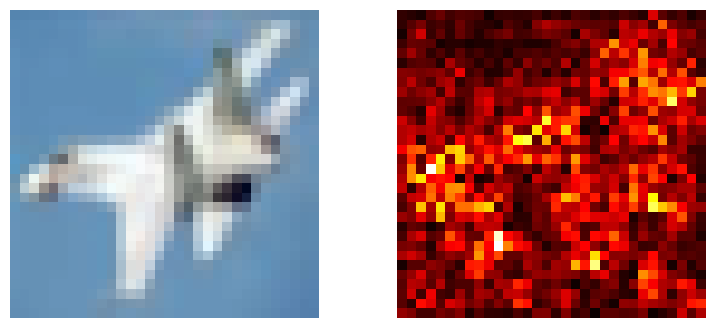

In [ ]:
saliency_map(image)

torch.Size([1, 3, 32, 32])


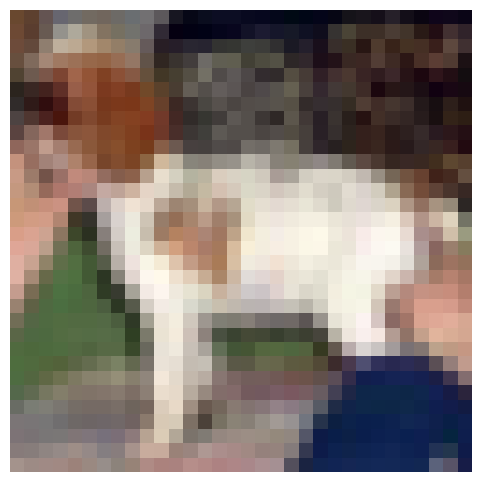

Actual labels: dog


In [ ]:
subset_indices = [12] # select your indices here as a list
image, label = show_image(subset_indices, test_dataset)

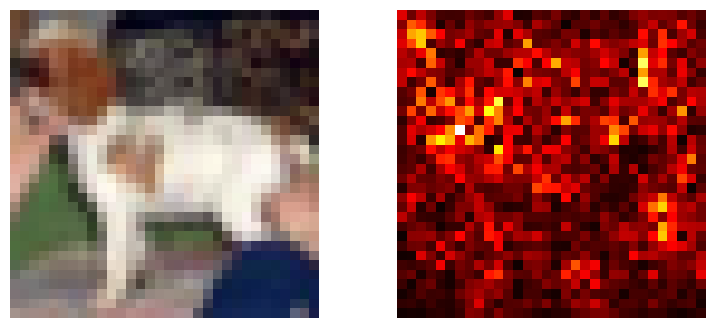

In [ ]:
saliency_map(image)

torch.Size([1, 3, 32, 32])


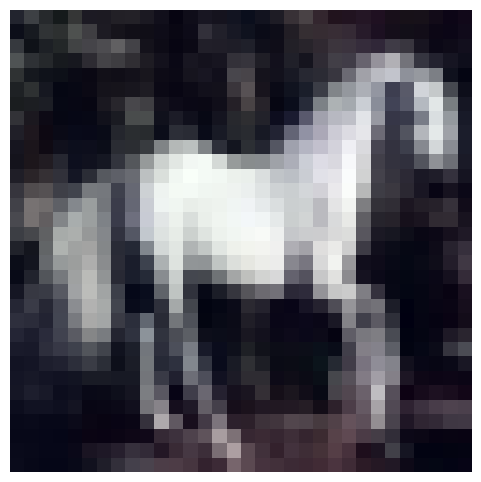

Actual labels: horse


In [ ]:
subset_indices = [13] # select your indices here as a list
image, label = show_image(subset_indices, test_dataset)

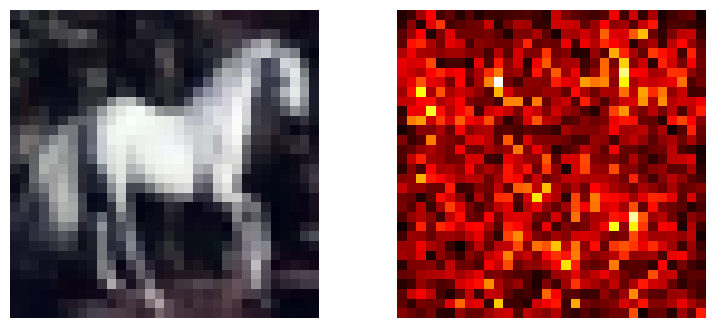

In [ ]:
saliency_map(image)

torch.Size([1, 3, 32, 32])


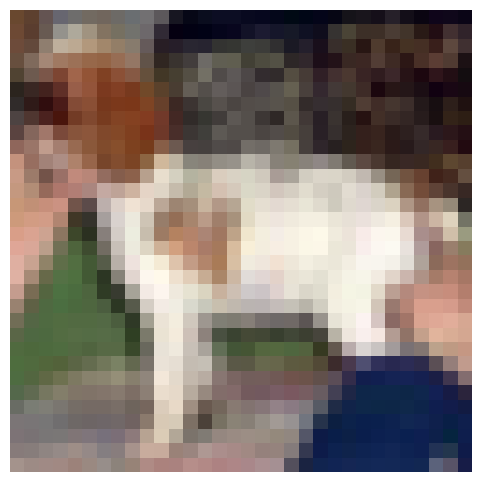

Actual labels: dog


In [ ]:
subset_indices = [12] # select your indices here as a list
image, label = show_image(subset_indices, test_dataset)

## Occlusion

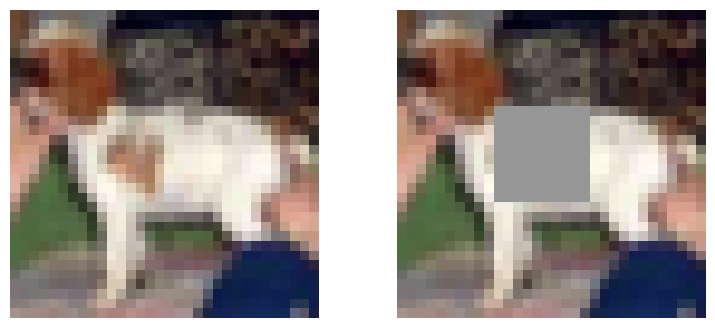

In [ ]:
# Define the mask (1 for keep, 0 for mask)
mask = torch.ones_like(image)  # Initially, set to 1 for the entire image

# Define the coordinates of the region to mask
start_x, start_y = 10, 10  # Starting coordinates of the masked region
mask[:, :, start_x:start_x + 10, start_y:start_y + 10] = 0  # Set a region to 0 (mask)

masked_images = image * mask

# Create a new figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))  # Adjust the figure size

# Display the original image on the left subplot
ax1.imshow(np.transpose(torchvision.utils.make_grid(
  image, normalize=True, padding=0, nrow=1).numpy(), (1, 2, 0))
)
ax1.set_axis_off()

# Display masked image on the right subplot
ax2.imshow(np.transpose(torchvision.utils.make_grid(
  masked_images, normalize=True, padding=0, nrow=1).numpy(), (1, 2, 0))
)
ax2.set_axis_off()

plt.subplots_adjust(wspace=0)  # Remove space between subplots
plt.show()

In [ ]:
outputs = model(image)
predicted_scores = torch.softmax(outputs, dim=1)
print(f"Initial Predicted Score of actual label: {predicted_scores[0][label.item()]}")

outputs = model(masked_images)

# Calculate prediction labels from model outputs
_, y_pred = torch.max(outputs.data, 1)
y_true = label

# Get the predicted score (probability) for the predicted label
predicted_scores = torch.softmax(outputs, dim=1)

print(f"Actual labels: {names[y_true]}, Predicted labels: {names[y_pred]}, Predicted Score of actual label: {predicted_scores[0][label.item()]}")


Initial Predicted Score of actual label: 0.997199535369873
Actual labels: dog, Predicted labels: dog, Predicted Score of actual label: 0.6211525201797485


torch.Size([1, 3, 32, 32])


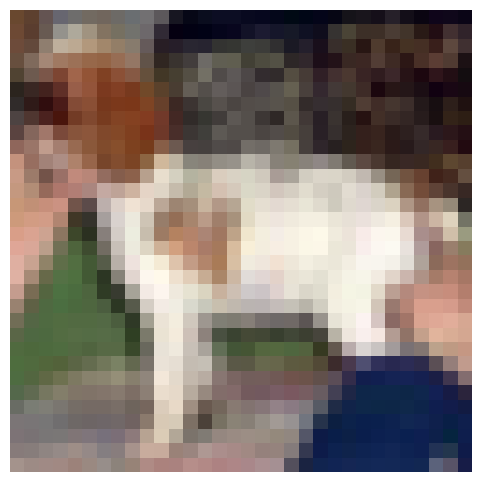

Actual labels: dog


In [ ]:
subset_indices = [12] # select your indices here as a list
image, label = show_image(subset_indices, test_dataset)

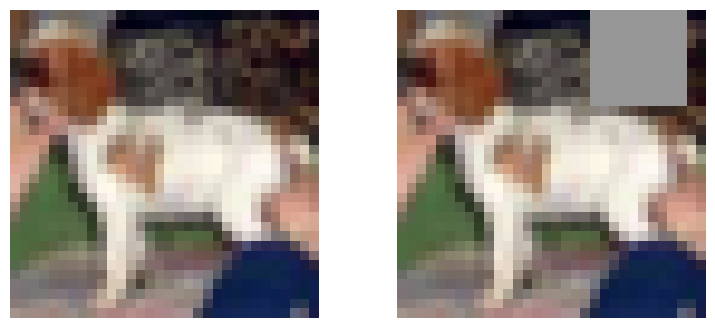

In [ ]:
# Define the mask (1 for keep, 0 for mask)
mask = torch.ones_like(image)  # Initially, set to 1 for the entire image

# Define the coordinates of the region to mask
start_x, start_y = 0, 20  # Starting coordinates of the masked region
mask[:, :, start_x:start_x + 10, start_y:start_y + 10] = 0  # Set a region to 0 (mask)

masked_images = image * mask

# Create a new figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))  # Adjust the figure size

# Display the original image on the left subplot
ax1.imshow(np.transpose(torchvision.utils.make_grid(
  image, normalize=True, padding=0, nrow=1).numpy(), (1, 2, 0))
)
ax1.set_axis_off()

# Display masked image on the right subplot
ax2.imshow(np.transpose(torchvision.utils.make_grid(
  masked_images, normalize=True, padding=0, nrow=1).numpy(), (1, 2, 0))
)
ax2.set_axis_off()

plt.subplots_adjust(wspace=0)  # Remove space between subplots
plt.show()

In [ ]:
outputs = model(image)
predicted_scores = torch.softmax(outputs, dim=1)
print(f"Initial Predicted Score of actual label: {predicted_scores[0][label.item()]}")

outputs = model(masked_images)

# Calculate prediction labels from model outputs
_, y_pred = torch.max(outputs.data, 1)
y_true = label

# Get the predicted score (probability) for the predicted label
predicted_scores = torch.softmax(outputs, dim=1)

print(f"Actual labels: {names[y_true]}, Predicted labels: {names[y_pred]}, Predicted Score of actual label: {predicted_scores[0][label.item()]}")


Initial Predicted Score of actual label: 0.997199535369873
Actual labels: dog, Predicted labels: cat, Predicted Score of actual label: 0.0010476794559508562


torch.Size([1, 3, 32, 32])


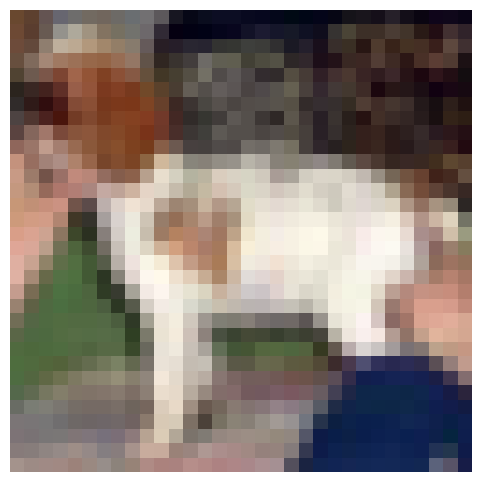

Actual labels: dog


In [ ]:
subset_indices = [12] # select your indices here as a list
image, label = show_image(subset_indices, test_dataset)

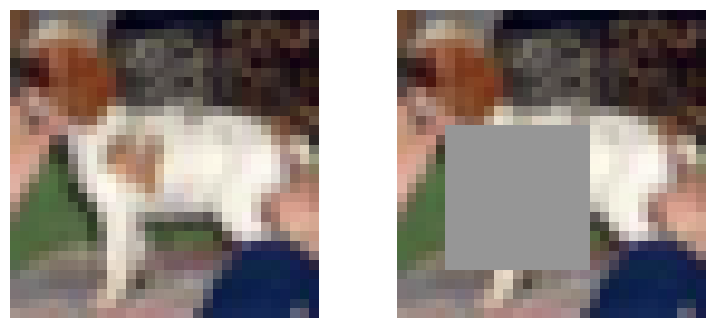

In [ ]:
# Define the mask (1 for keep, 0 for mask)
mask = torch.ones_like(image)  # Initially, set to 1 for the entire image

# Define the coordinates of the region to mask
start_x, start_y = 12, 5   # Starting coordinates of the masked region
mask[:, :, start_x:start_x + 15, start_y:start_y + 15] = 0  # Set a region to 0 (mask)

masked_images = image * mask

# Create a new figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))  # Adjust the figure size

# Display the original image on the left subplot
ax1.imshow(np.transpose(torchvision.utils.make_grid(
  image, normalize=True, padding=0, nrow=1).numpy(), (1, 2, 0))
)
ax1.set_axis_off()

# Display masked image on the right subplot
ax2.imshow(np.transpose(torchvision.utils.make_grid(
  masked_images, normalize=True, padding=0, nrow=1).numpy(), (1, 2, 0))
)
ax2.set_axis_off()

plt.subplots_adjust(wspace=0)  # Remove space between subplots
plt.show()

In [ ]:
outputs = model(image)
predicted_scores = torch.softmax(outputs, dim=1)
print(f"Initial Predicted Score of actual label: {predicted_scores[0][label.item()]}")

outputs = model(masked_images)

# Calculate prediction labels from model outputs
_, y_pred = torch.max(outputs.data, 1)
y_true = label

# Get the predicted score (probability) for the predicted label
predicted_scores = torch.softmax(outputs, dim=1)

print(f"Actual labels: {names[y_true]}, Predicted labels: {names[y_pred]}, Predicted Score of actual label: {predicted_scores[0][label.item()]}")


Initial Predicted Score of actual label: 0.997199535369873
Actual labels: dog, Predicted labels: cat, Predicted Score of actual label: 0.050775185227394104
